In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import openmc
import openmc.mgxs as mgxs
import openmc.data

%matplotlib inline

In [2]:
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide('U235', 0.03)
fuel.add_nuclide('U238', 0.97)
fuel.add_nuclide('O16', 2.0)

water = openmc.Material(name='Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')


In [3]:
# Instantiate a Materials collection
materials_file = openmc.Materials([fuel, water])

# Export to "materials.xml"
materials_file.export_to_xml()

In [4]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)


In [5]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='Clad')
# clad_cell.fill = fuel
# clad_cell.region = +fuel_outer_radius & -clad_outer_radius
# pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='Moderator')
moderator_cell.fill = water
moderator_cell.region = +fuel_outer_radius
pin_cell_universe.add_cell(moderator_cell)

In [6]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
box = openmc.get_rectangular_prism(width=1.26, height=1.26,
                                   boundary_type='reflective')
root_cell.region = box
root_cell.fill = pin_cell_universe

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

In [7]:
# Create Geometry and set root Universe
openmc_geometry = openmc.Geometry(root_universe)

# Export to "geometry.xml"
openmc_geometry.export_to_xml()

In [8]:
# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = 50                # 50
settings_file.inactive = 10               # 10
settings_file.particles = 100             # 10000
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Activate tally precision triggers
settings_file.trigger_active = True
settings_file.trigger_max_batches = settings_file.batches * 4

# Export to "settings.xml"
settings_file.export_to_xml()

In [9]:
# Instantiate a "coarse" 2-group EnergyGroups object
coarse_groups = mgxs.EnergyGroups([0., 0.625, 20.0e6])

# Instantiate a "fine" 8-group EnergyGroups object
fine_groups = mgxs.EnergyGroups([0., 0.058, 0.14, 0.28,
                                 0.625, 4.0, 5.53e3, 821.0e3, 20.0e6])

In [10]:
# Extract all Cells filled by Materials
openmc_cells = openmc_geometry.get_all_material_cells().values()

# Create dictionary to store multi-group cross sections for all cells
xs_library = {}

# Instantiate 8-group cross sections for each cell
for cell in openmc_cells:
    xs_library[cell.id] = {}
    xs_library[cell.id]['transport']  = mgxs.TransportXS(groups=fine_groups)
    xs_library[cell.id]['fission']    = mgxs.FissionXS(groups=fine_groups)
    xs_library[cell.id]['nu-fission'] = mgxs.FissionXS(groups=fine_groups, nu=True)
    xs_library[cell.id]['nu-scatter'] = mgxs.ScatterMatrixXS(groups=fine_groups, nu=True)
    xs_library[cell.id]['chi']        = mgxs.Chi(groups=fine_groups)

In [11]:
# Create a tally trigger for +/- 0.01 on each tally used to compute the multi-group cross sections
tally_trigger = openmc.Trigger('std_dev', 1E-2)

# Add the tally trigger to each of the multi-group cross section tallies
for cell in openmc_cells:
    for mgxs_type in xs_library[cell.id]:
        xs_library[cell.id][mgxs_type].tally_trigger = tally_trigger

In [12]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()

# Iterate over all cells and cross section types
for cell in openmc_cells:
    for rxn_type in xs_library[cell.id]:

        # Set the cross sections domain to the cell
        xs_library[cell.id][rxn_type].domain = cell
        
        # Tally cross sections by nuclide
        xs_library[cell.id][rxn_type].by_nuclide = True
                
        # Add OpenMC tallies to the tallies file for XML generation
        for tally in xs_library[cell.id][rxn_type].tallies.values():
            tallies_file.append(tally, merge=True)

# Export to "tallies.xml"
tallies_file.export_to_xml()

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=26.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=14.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=5.
  warn(msg, IDWarning)


In [13]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

In [14]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.082.h5')

# Iterate over all cells and cross section types
for cell in openmc_cells:
    for rxn_type in xs_library[cell.id]:
        xs_library[cell.id][rxn_type].load_from_statepoint(sp)

In [15]:
# nufission = xs_library[fuel_cell.id]['nu-fission']
# nufission.print_xs(xs_type='micro', nuclides=['U235', 'U238'])

In [16]:
# nufission = xs_library[fuel_cell.id]['nu-fission']
# nufission.print_xs(xs_type='macro', nuclides='sum')

In [17]:
nuscatter = xs_library[moderator_cell.id]['nu-scatter']
df = nuscatter.get_pandas_dataframe(xs_type='micro')
df.head(10)

,cell,group in,group out,nuclide,mean,std. dev.
126,3,1,1,H1,0.233961,0.003751
127,3,1,1,O16,1.569313,0.006360
124,3,1,2,H1,1.587080,0.003098
125,3,1,2,O16,0.285604,0.001422
122,3,1,3,H1,0.010480,0.000220
123,3,1,3,O16,0.000000,0.000000
120,3,1,4,H1,0.000009,0.000006
121,3,1,4,O16,0.000000,0.000000
118,3,1,5,H1,0.000005,0.000005
119,3,1,5,O16,0.000000,0.000000


In [18]:
# Extract the 8-group transport cross section for the fuel
fine_xs = xs_library[fuel_cell.id]['transport']

# Condense to the 2-group structure
condensed_xs = fine_xs.get_condensed_xs(coarse_groups)

In [19]:
df = condensed_xs.get_pandas_dataframe(xs_type='micro')
df


,cell,group in,nuclide,mean,std. dev.
3,1,1,U235,11.283238,0.023961
4,1,1,U238,9.712667,0.010907
5,1,1,O16,3.157212,0.003531
0,1,2,U235,263.752461,0.505898
1,1,2,U238,11.355341,0.021462
2,1,2,O16,3.788309,0.007676


(1.0000000000000001e-05, 20000000.0)

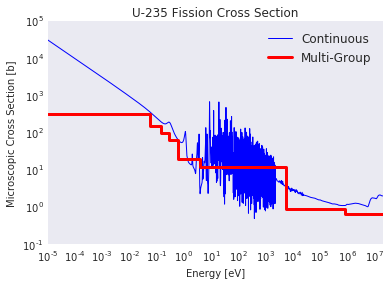

In [20]:
# Create a figure of the U-235 continuous-energy fission cross section 
fig = openmc.plot_xs('U235', ['fission'])

# Get the axis to use for plotting the MGXS
ax = fig.gca()

# Extract energy group bounds and MGXS values to plot
fission = xs_library[fuel_cell.id]['fission']
energy_groups = fission.energy_groups
x = energy_groups.group_edges
y = fission.get_xs(nuclides=['U235'], order_groups='decreasing', xs_type='micro')
y = np.squeeze(y)

# Fix low energy bound
x[0] = 1.e-5

# Extend the mgxs values array for matplotlib's step plot
y = np.insert(y, 0, y[0])

# Create a step plot for the MGXS
ax.plot(x, y, drawstyle='steps', color='r', linewidth=3)

ax.set_title('U-235 Fission Cross Section')
ax.legend(['Continuous', 'Multi-Group'])
ax.set_xlim((x.min(), x.max()))